In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import shap

import math

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="muted")
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [72]:
def plot_data_rolling(data: pd.DataFrame, title:str, rolling: bool = False, window: int = 24) -> None:

    f, ax = plt.subplots(figsize=(15,5))

    ax.plot(data.values)

    if rolling:
        rolling_mean = data.rolling(window=window).mean()
        ax.plot(rolling_mean.values, c='red')

    f.tight_layout();
    ax.set_ylabel(title)

    plt.show();

In [77]:
def smooth_data_moving_average(
    series: pd.DataFrame,
    window: int,
    scale: int = 1.96,
    fill: bool = True
) -> None:

    """
        Smooth data INPLACE!!!!!

        Input - DateFrame with ONE column        

        series - dataframe with timeseries
        window - rolling window size 
    """
    rolling_mean = series.rolling(window=window).mean()

    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)

    series.loc[(series < lower_bond) | (series > upper_bond)] = np.NaN
    
    if fill:
        series.ffill(inplace=True)


In [78]:
WORK_DIR = 'working_data'
FILE_NAME = 'df_work_ds_final.zip'

In [147]:
filepath = Path(f'./{WORK_DIR}/{FILE_NAME}')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [148]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

График измерения железа 2+ до обработки.

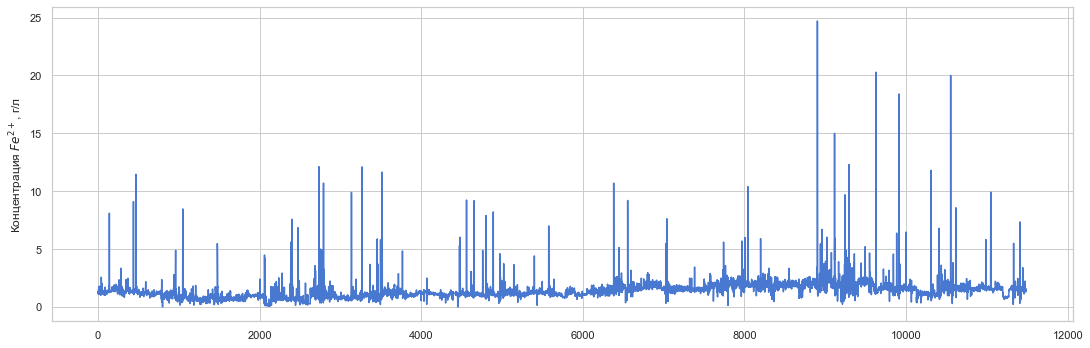

In [149]:
plot_data_rolling(df['Fe2+'], title='Концентрация $Fe^{2+}$, г/л')

Сгладим данные и уберем точки которые на $2\sigma$ отличаются от среднего значения за 12 часов.

In [150]:
for col in df.columns:
    smooth_data_moving_average(df[col], window=12)

Выведем график железа 2+ после обработки.

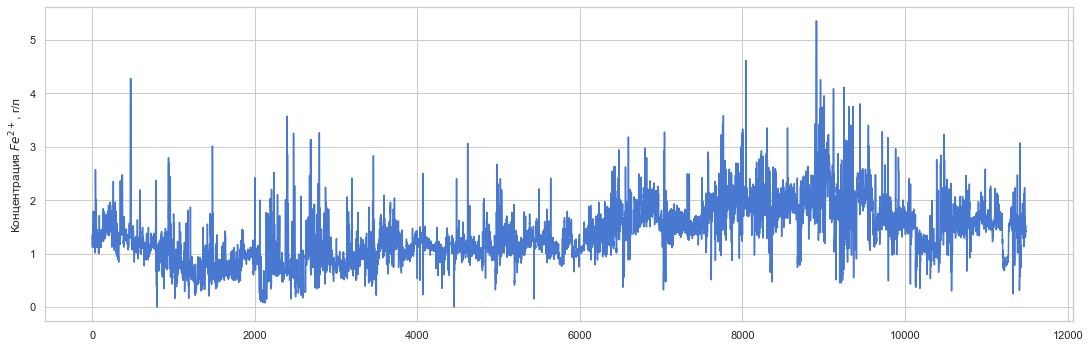

In [151]:
plot_data_rolling(df['Fe2+'], title='Концентрация $Fe^{2+}$, г/л')

Используем модель CatBoost для предсказания значений Fe2+. Все будем использовать аналогично Sample_model

In [152]:
df['lag'] = df['Fe2+'].shift(2)
df.dropna(axis=0, inplace=True)

X = df.drop(['Fe2+', 'lag'], axis=1)
y = df['lag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

In [153]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(train_data)

Learning rate set to 0.057923
0:	learn: 0.5280421	total: 5.35ms	remaining: 5.35s
1:	learn: 0.5150820	total: 12.1ms	remaining: 6.05s
2:	learn: 0.5020068	total: 21.1ms	remaining: 7.01s
3:	learn: 0.4906897	total: 26.4ms	remaining: 6.58s
4:	learn: 0.4803179	total: 33.5ms	remaining: 6.66s
5:	learn: 0.4708269	total: 41.4ms	remaining: 6.85s
6:	learn: 0.4610421	total: 47.5ms	remaining: 6.74s
7:	learn: 0.4525247	total: 53.5ms	remaining: 6.64s
8:	learn: 0.4440626	total: 61ms	remaining: 6.71s
9:	learn: 0.4373260	total: 66ms	remaining: 6.53s
10:	learn: 0.4303548	total: 71.9ms	remaining: 6.46s
11:	learn: 0.4245622	total: 78.9ms	remaining: 6.5s
12:	learn: 0.4183231	total: 84.3ms	remaining: 6.4s
13:	learn: 0.4134910	total: 89.1ms	remaining: 6.28s
14:	learn: 0.4081280	total: 97.5ms	remaining: 6.4s
15:	learn: 0.4030367	total: 102ms	remaining: 6.27s
16:	learn: 0.3980099	total: 108ms	remaining: 6.26s
17:	learn: 0.3940281	total: 113ms	remaining: 6.16s
18:	learn: 0.3898815	total: 117ms	remaining: 6.05s
19:

In [154]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)

print("Метрики качества")
print("RMSE: {:.2f}".format(rmse))
print("MAE: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))

Метрики качества
RMSE: 0.28
MAE: 0.18
R2: 0.73


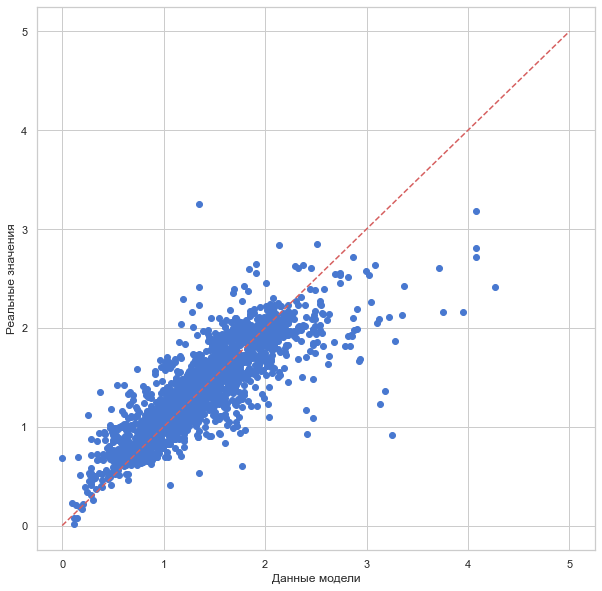

In [164]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.values, pred)

scale = math.ceil(max(y_test.values.max(), pred.max()))
plt.plot([0, scale], [0, scale], 'r--')

plt.xlabel("Данные модели")
plt.ylabel("Реальные значения")

plt.show();

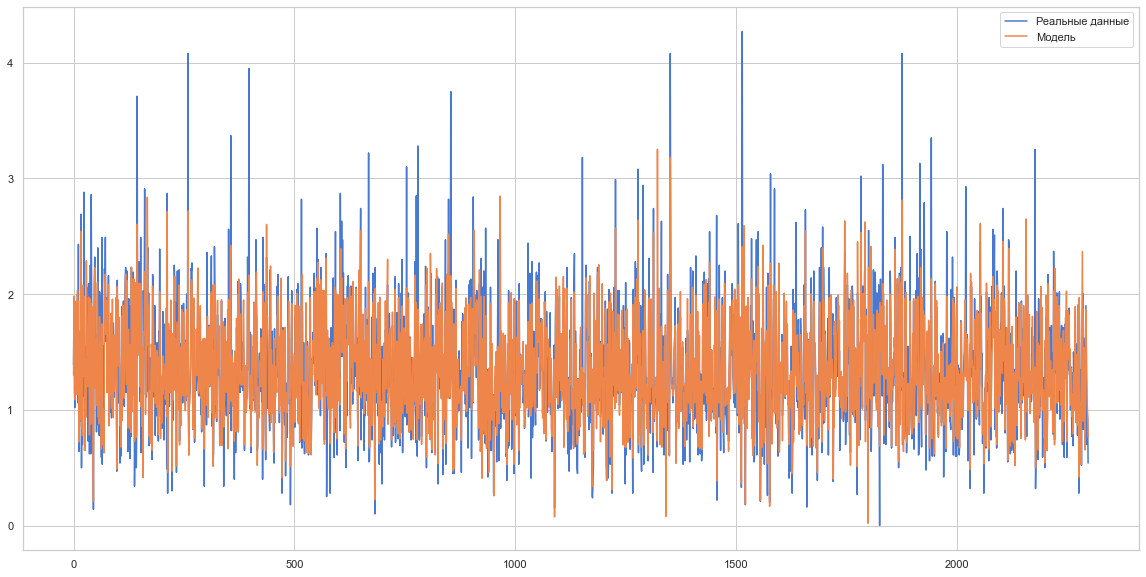

In [156]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values, label='Реальные данные')
plt.plot(pred, label='Модель')

plt.legend()
plt.show();

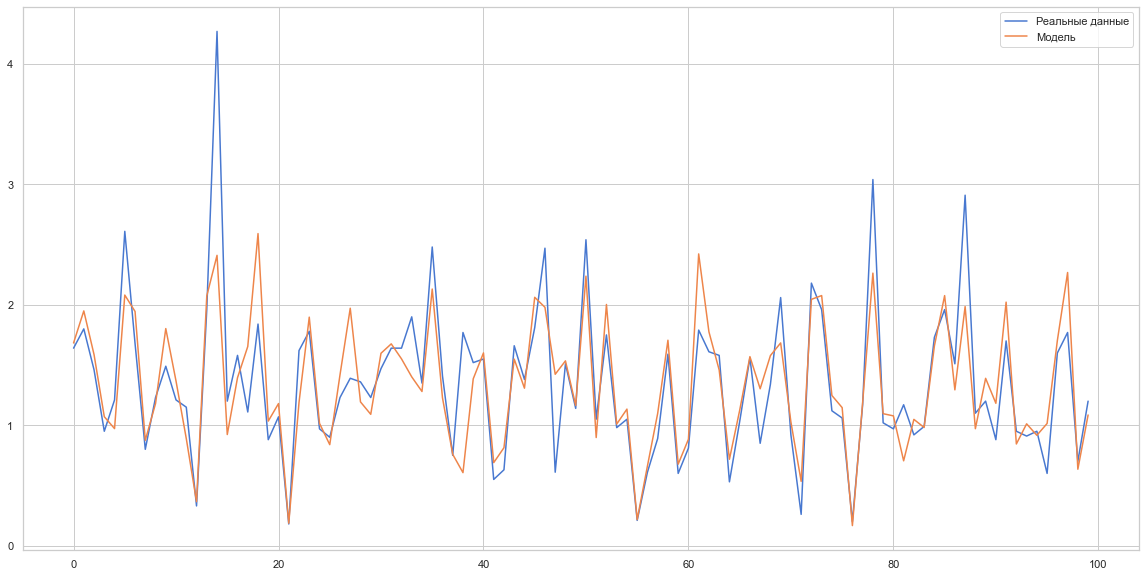

In [157]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values[1500:1600], label='Реальные данные')
plt.plot(pred[1500:1600], label='Модель')

plt.legend()
plt.show();

Посмотрим, какие признаки больше всего влияют на модель.

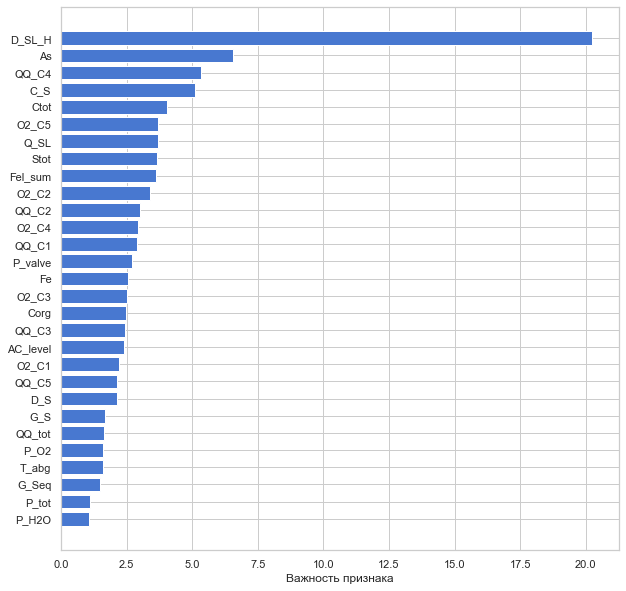

In [158]:
sorted_feature_importance = model.feature_importances_.argsort()

plt.figure(figsize=(10,10))
plt.barh(X.columns[sorted_feature_importance], model.feature_importances_[sorted_feature_importance])
plt.xlabel("Важность признака")
plt.show();

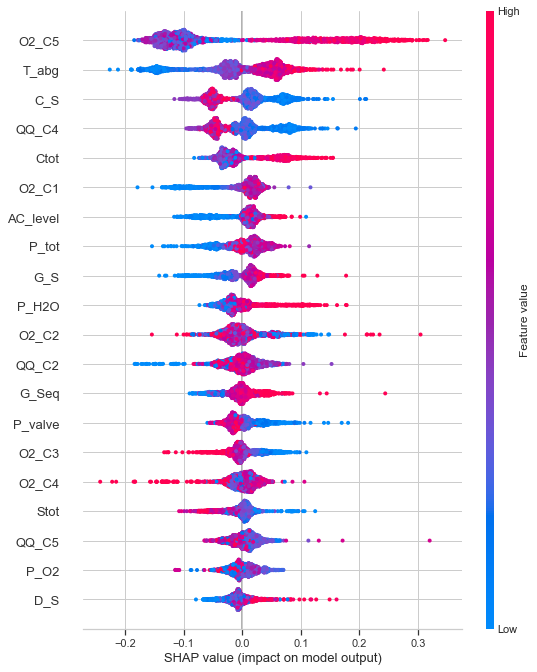

In [159]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X.columns[sorted_feature_importance])